In [1]:
import jax
import jax.numpy as jnp
from jax import random, vmap, jit, grad, value_and_grad, jacfwd, jacrev
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt
import optax
import equinox as eqx
from equinox import filter_jit, filter_grad, partition, combine, filter_value_and_grad
from modules.models import FourierFeatures, DeepONet
from torch.utils.data import Dataset
from functools import partial
import sys, os, time

In [2]:
# sensors_mean = 0.
# sensors_std = 1.
N_SENSORS = 200
LATENT_DIM = 200
INPUT_DIM = 1
OUTPUT_DIM = 1
N_FUNCTIONS = 5000
N_INPUTS = 200
KERNEL_LEN = 0.1
BATCH_SIZE = 10000 
NUM_STEPS = N_INPUTS * N_FUNCTIONS // BATCH_SIZE
BATCH_SIZE_BOUNDARY = 200
EPOCHS = 300
FOURIER_FREQS = 100

In [3]:
NUM_STEPS

100

In [4]:
def loss_fn_data(model, sensors, inputs, labels):
    preds = vmap(model, in_axes=(0, 0))(sensors, inputs)
    return jnp.mean((preds - labels) ** 2)

def loss_fn_residual_antiderivative(model, sensors, inputs, residuals):
    error = vmap(jacfwd(model, argnums=1), in_axes=(0, 0))(sensors, inputs)[:, 0] - residuals
    print(error.shape)
    return jnp.mean(error ** 2)

In [5]:
def fit(model, collocation_dataiter, boundary_dataiter, epochs, optimizer, opt_state=None):
    if opt_state is None:
        opt_state = optimizer.init(eqx.filter(model, eqx.is_array))
    
    @filter_jit
    def _train_step(model, opt_state, collocation_batch, boundary_batch):
        sensors_colloc, inputs_colloc, residuals_colloc, _ = collocation_batch
        sensors_boundary, inputs_boundary, _, labels_boundary = boundary_batch
        loss_data, grads_data = filter_value_and_grad(loss_fn_data)(model, sensors_boundary, inputs_boundary, labels_boundary)
        loss_residual, grads_residual = filter_value_and_grad(loss_fn_residual_antiderivative)(model, sensors_colloc, inputs_colloc, residuals_colloc)
        grads = jax.tree_map(lambda g1, g2: 1e-2 * g1 + g2, grads_data, grads_residual)
        updates, opt_state = optimizer.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return loss_data, loss_residual, model, opt_state
    
    for epoch in range(epochs):
        for batch in range(NUM_STEPS):
            colloc_batch = next(collocation_dataiter)
            boundary_batch = next(boundary_dataiter)
            
            loss_data, loss_residual, model, opt_state = _train_step(model, opt_state, colloc_batch, boundary_batch)
            if batch % 25 == 0:
                print(f"Epoch {epoch}, batch {batch}, loss residual {loss_residual}, loss data {loss_data}")
    return model, opt_state


In [6]:
class DataGenerator(Dataset):
    def __init__(self, sensors, inputs, residuals, labels, batch_size=128, key=random.PRNGKey(0)):
        self.sensors = sensors
        self.inputs = inputs
        self.labels = labels
        self.residuals = residuals
        self.key = key
        self.batch_size = batch_size
        self.N = self.inputs.shape[0]

    def __getitem__(self, item):
        self.key, subkey = random.split(self.key)
        inputs, sensors, residuals, labels = self.__data_generation(subkey)
        return inputs, sensors, residuals, labels

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        idx = random.choice(key, self.N, shape=(self.batch_size,), replace=False)
        return self.sensors[idx, :], self.inputs[idx, :], self.residuals[idx, :], self.labels[idx, :]


In [7]:
def rbf_kernel(x1, x2, params):
    output_scale, length_scale = params
    diff = (x1[:, None] - x2[None, :]) ** 2
    return output_scale * jnp.exp(-0.5 * diff / length_scale ** 2)

def generate_gaussian_function(key, n_sensors, n_inputs, kernel_len, n_mesh=1000):
    key, subkey = random.split(key)
    x = jnp.linspace(0., 1., n_mesh, dtype=jnp.float32)
    # covariance matrix of the Gaussian process with RBF kernel
    cov = rbf_kernel(x, x, (1., kernel_len))
    chol_factor = jnp.linalg.cholesky(cov + 1e-2 * jnp.eye(n_mesh))
    # sample from the Gaussian process
    gp = jnp.dot(chol_factor, random.normal(key, (n_mesh,), dtype=jnp.float32))
    gp_fn = lambda _, t: jnp.interp(t, x, gp)
    sensors = vmap(gp_fn, in_axes=(None, 0))(0, jnp.linspace(0., 1., n_sensors, dtype=jnp.float32))
    inputs = random.uniform(subkey, (n_inputs,), dtype=jnp.float32, minval=0.0, maxval=1.0).sort()
    solution = odeint(gp_fn, 0.0, jnp.hstack((0.0, inputs)))[1:]
    residuals = vmap(gp_fn, in_axes=(None, 0))(0, inputs)
    return sensors, inputs, residuals, solution

def generate_data(n_sesnors, n_functions, n_inputs, kernel_len, n_mesh=1000, key=random.PRNGKey(0)):
    keys = random.split(key, n_functions)
    sensors, inputs, residuals, solutions = vmap(generate_gaussian_function,
                                      in_axes=(0, None, None, None, None))(keys, n_sesnors, n_inputs, kernel_len, n_mesh)

    sensors = jnp.tile(sensors, (1, n_inputs)).reshape(-1, n_sesnors)
    return sensors, inputs.reshape(-1, 1), residuals.reshape(-1, 1), solutions.reshape(-1, 1)

In [8]:
sensors, inputs, residuals, sols = generate_data(N_SENSORS, N_FUNCTIONS, N_INPUTS, KERNEL_LEN)
colloc_gen = DataGenerator(sensors, inputs, residuals, sols, batch_size=BATCH_SIZE)

sensors_boundary = sensors[::N_INPUTS]
inputs_initial = jnp.zeros((N_FUNCTIONS, 1), dtype=jnp.float32)
labels_initial = jnp.zeros((N_FUNCTIONS, 1), dtype=jnp.float32)
initial_gen = DataGenerator(sensors_boundary, inputs_initial, labels_initial, labels_initial, batch_size=BATCH_SIZE_BOUNDARY)

In [9]:
branch_layers = [N_SENSORS, 200, 200, 200, 200, 200, LATENT_DIM]
trunk_layers = [INPUT_DIM, 200, 200, 200, 200, 200, LATENT_DIM]
activation = jnp.tanh
keys_branch = random.split(random.PRNGKey(0), len(branch_layers) - 1)
keys_trunk = random.split(random.PRNGKey(1), len(trunk_layers) - 1)

In [10]:
layers = []
for in_dim, out_dim, key in zip(branch_layers[:-2], branch_layers[1:-1], keys_branch[:-1]):
    layers.append(eqx.nn.Linear(in_dim, out_dim, key=key))
    layers.append(eqx.nn.Lambda(activation))
layers.append(eqx.nn.Linear(branch_layers[-2], branch_layers[-1], key=keys_branch[-1]))
branch_net = eqx.nn.Sequential(layers)

In [11]:
layers = []
for in_dim, out_dim, key in zip(trunk_layers[:-2], trunk_layers[1:-1], keys_trunk[:-1]):
    layers.append(eqx.nn.Linear(in_dim, out_dim, key=key))
    layers.append(eqx.nn.Lambda(activation))
layers.append(eqx.nn.Linear(trunk_layers[-2], trunk_layers[-1], key=keys_trunk[-1]))
trunk_net = eqx.nn.Sequential(layers)

In [12]:
opt_adam = optax.adam(optax.exponential_decay(1e-5, NUM_STEPS, 0.975))
donet = DeepONet(branch_net, trunk_net)

In [13]:
donet, opt_state = fit(donet, iter(colloc_gen), iter(initial_gen), EPOCHS, opt_adam)

(10000, 1)
Epoch 0, batch 0, loss residual 1.019168496131897, loss data 0.000572608201764524
Epoch 0, batch 25, loss residual 0.9563522934913635, loss data 0.0017431986052542925
Epoch 0, batch 50, loss residual 0.8703597187995911, loss data 0.006170656066387892
Epoch 0, batch 75, loss residual 0.7981758713722229, loss data 0.019808543846011162
Epoch 1, batch 0, loss residual 0.7467207908630371, loss data 0.0396086648106575
Epoch 1, batch 25, loss residual 0.7456264495849609, loss data 0.054954756051301956
Epoch 1, batch 50, loss residual 0.7370859980583191, loss data 0.09630022943019867
Epoch 1, batch 75, loss residual 0.6927275657653809, loss data 0.262285977602005
Epoch 2, batch 0, loss residual 0.6381348967552185, loss data 0.8953271508216858
Epoch 2, batch 25, loss residual 0.5855578780174255, loss data 1.6931670904159546
Epoch 2, batch 50, loss residual 0.5858364105224609, loss data 0.900254487991333
Epoch 2, batch 75, loss residual 0.5904761552810669, loss data 0.594309389591217


In [14]:
sensor_test = 2. * jnp.pi * jnp.tile(jnp.cos(2. * jnp.pi * jnp.linspace(0., 1., 200, dtype=jnp.float32)).reshape(1, -1), (200, 1))
input_test = jnp.linspace(0., 1., 200, dtype=jnp.float32).reshape(-1, 1)
label_test = jnp.sin(2. * jnp.pi * jnp.linspace(0., 1., 200, dtype=jnp.float32)).reshape(-1, 1)
out = vmap(donet, in_axes=(0, 0))(sensor_test, input_test)

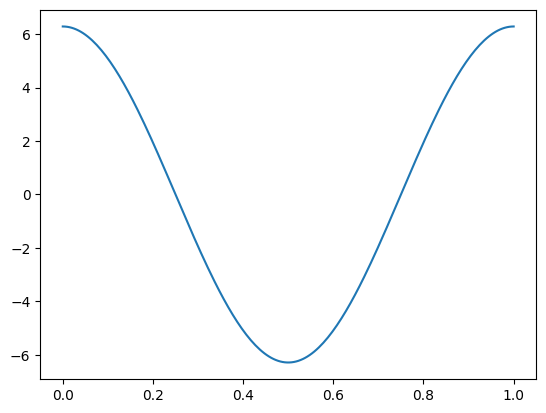

In [15]:
plt.plot(input_test, sensor_test[0])

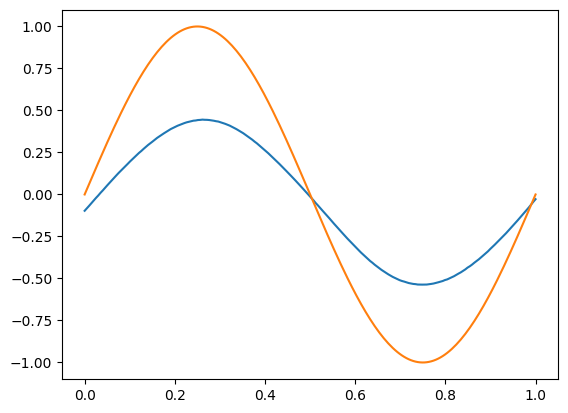

In [16]:
plt.plot(input_test, out)
plt.plot(input_test, label_test)